# Imports

In [1]:
import os, gc
import torch
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None)

# Initial setup

## GPU

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


## Pytorch lightning and forecasting

In [3]:
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer

# Load input

In [4]:
from dataclasses import dataclass

@dataclass
class args:
    result_folder = '../results/cleaned target/top_100_early_stopped_target_cleaned_scaled/' 
    figPath = os.path.join(result_folder, 'figures')
    checkpoint_folder = os.path.join(result_folder, 'checkpoints')
    input_filePath = '../2022_May_cleaned/Top_100.csv'

    configPath = '../config_2022_May.json'
    model_path = os.path.join(checkpoint_folder, 'best-epoch=9.ckpt')

    # set this to false when submitting batch script, otherwise it prints a lot of lines
    show_progress_bar = True

    # interpret_output has high memory requirement
    # results in out-of-memery for Total.csv and a model of hidden size 64, even with 64GB memory
    interpret_train = 'Total.csv' not in input_filePath

In [5]:
start = datetime.now()
print(f'Started at {start}')

total_data = pd.read_csv(args.input_filePath)
print(total_data.shape)
total_data.head()

Started at 2022-10-20 13:00:46.256242
(81800, 15)


,FIPS,AgeDist,HealthDisp,Name,Date,DiseaseSpread,Transmission,VaccinationFull,SocialDist,Cases,Deaths,TimeFromStart,LinearSpace,SinWeekly,CosWeekly
0,4013,0.4991,0.3334,"Arizona, Maricopa",2020-02-28,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0328,-0.4339,-0.9010
1,4013,0.4991,0.3334,"Arizona, Maricopa",2020-02-29,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0328,-0.9749,-0.2225
2,4013,0.4991,0.3334,"Arizona, Maricopa",2020-03-01,0.0,0.0,0.0,1.0,0.0,0.0,2,0.0328,-0.7818,0.6235
3,4013,0.4991,0.3334,"Arizona, Maricopa",2020-03-02,0.0,0.0,0.0,1.0,0.0,0.0,3,0.0328,0.0000,1.0000
4,4013,0.4991,0.3334,"Arizona, Maricopa",2020-03-03,0.0,0.0,0.0,1.0,0.0,0.0,4,0.0328,0.7818,0.6235


# Config

In [6]:
import json
import sys
sys.path.append( '..' )
from Class.Parameters import Parameters
from script.utils import *

with open(args.configPath, 'r') as input_file:
  config = json.load(input_file)

parameters = Parameters(config, **config)

In [7]:
targets = parameters.data.targets
time_idx = parameters.data.time_idx
tft_params = parameters.model_parameters

batch_size = tft_params.batch_size
max_prediction_length = tft_params.target_sequence_length
max_encoder_length = tft_params.input_sequence_length

# Processing

In [8]:
total_data['Date'] = pd.to_datetime(total_data['Date'].values) 
total_data['FIPS'] = total_data['FIPS'].astype(str)
print(f"There are {total_data['FIPS'].nunique()} unique counties in the dataset.")

There are 100 unique counties in the dataset.


## Adapt input to encoder length
Input data length needs to be a multiple of encoder length to created batch data loaders.

In [9]:
train_start = parameters.data.split.train_start
total_data = total_data[total_data['Date']>=train_start]
total_data[time_idx] = (total_data["Date"] - total_data["Date"].min()).apply(lambda x: x.days)

## Train validation test split and scaling

In [10]:
train_data, validation_data, test_data = train_validation_test_split(
    total_data, parameters
)

Train samples 64100, validation samples 2800, test samples 2800
641 days of training, 15 days of validation data, 15 days of test data.


In [11]:
train_scaled, validation_scaled, test_scaled, target_scaler = scale_data(
    train_data, validation_data, test_data, parameters
)

Scaling static and dynamic input features: ['AgeDist', 'HealthDisp', 'DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist']
Scaling targets ['Cases', 'Deaths']


## Create dataset and dataloaders

In [12]:
def prepare_data(data: pd.DataFrame, pm: Parameters, train=False):
  data_timeseries = TimeSeriesDataSet(
    data,
    time_idx= time_idx,
    target=targets,
    group_ids=pm.data.id, 
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals=pm.data.static_features,
    # static_categoricals=['FIPS'],
    time_varying_known_reals = pm.data.time_varying_known_features,
    time_varying_unknown_reals = pm.data.time_varying_unknown_features,
    target_normalizer = MultiNormalizer(
      [GroupNormalizer(groups=pm.data.id) for _ in range(len(targets))]
    )
  )

  if train:
    dataloader = data_timeseries.to_dataloader(train=True, batch_size=batch_size)
  else:
    dataloader = data_timeseries.to_dataloader(train=False, batch_size=batch_size*8)

  return dataloader

In [13]:
train_dataloader = prepare_data(train_scaled, parameters)
validation_dataloader = prepare_data(validation_scaled, parameters)
test_dataloader = prepare_data(test_scaled, parameters)

# del validation_scaled, test_scaled
gc.collect()

0

# Model

In [14]:
tft = TemporalFusionTransformer.load_from_checkpoint(args.model_path)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 231.8k


# Prediction Processor and PlotResults

In [15]:
from Class.PredictionProcessor import PredictionProcessor

processor = PredictionProcessor(
    time_idx, parameters.data.id[0], max_prediction_length, targets, 
    train_start, max_encoder_length
)

In [16]:
from Class.Plotter import *

plotter = PlotResults(args.figPath, targets, show=args.show_progress_bar)

# Evaluate

## Train results

### Average


---Training results--



Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Target Cases, MAE 121.05, RMSE 268.32, SMAPE 0.64552. NNSE 0.85207.
Target Deaths, MAE 2.5333, RMSE 4.8959, SMAPE 0.9391. NNSE 0.84375.



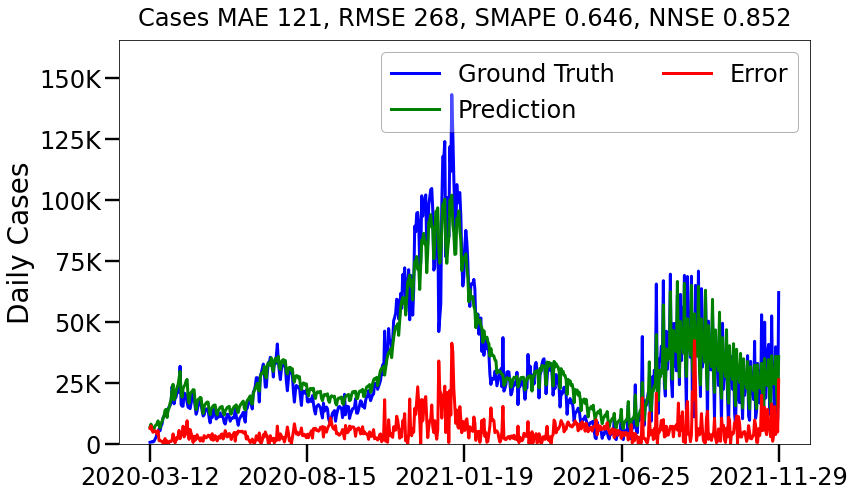

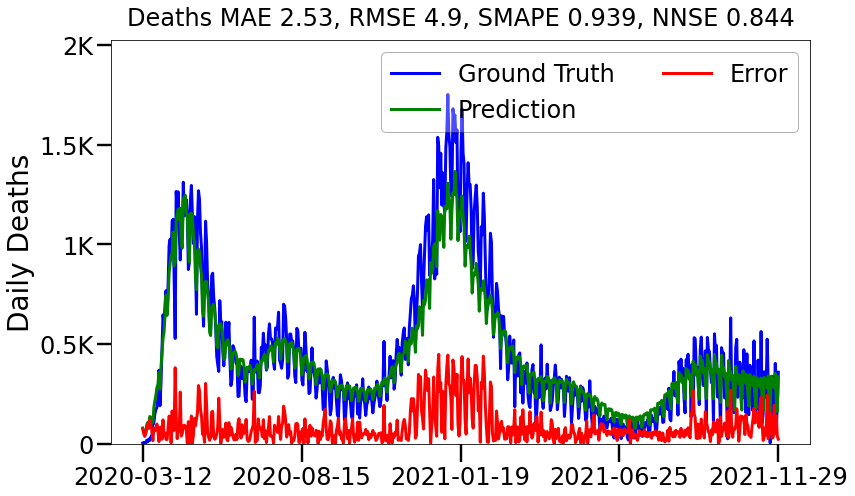

6372

In [17]:
print(f'\n---Training results--\n')

# [number of targets (2), number of examples, prediction length (15)]
train_raw_predictions, train_index = tft.predict(
    train_dataloader, return_index=True, show_progress_bar=args.show_progress_bar
)

train_predictions = upscale_prediction(targets, train_raw_predictions, target_scaler, max_prediction_length)
train_result_merged = processor.align_result_with_dataset(train_data, train_predictions, train_index)
show_result(train_result_merged, targets)

plotter.summed_plot(train_result_merged, type='Train_error', plot_error=True, save=False)
gc.collect()

In [18]:
def morris_method(model, original_data, original_prediction, feature, delta):
    data = original_data.copy()
    # data[feature] += delta
    noise = np.random.uniform(-delta, delta, data.shape[0])
    data[feature] += noise
    
    dataloader = prepare_data(data, parameters)

    raw_predictions = model.predict(
        dataloader, show_progress_bar=args.show_progress_bar
    )
    standard_deviation = original_data[feature].std()

    # raw_predictions[0] is cases, [1] is deaths
    mu_star = torch.sum(abs(original_prediction - raw_predictions[0])) / (data.shape[0]*delta)
    scaled_morris_index = mu_star * standard_deviation
    print(f'Feature {feature}, mu_star {mu_star:0.5g}, standard deviation {standard_deviation:0.5g}, sensitivity {scaled_morris_index:0.5g}')
    
    return scaled_morris_index

In [19]:
data = parameters.data
for feature in data.dynamic_features + data.static_features:
    morris_method(tft, train_scaled, train_raw_predictions[0], feature, 0.005)

Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Feature DiseaseSpread, mu_star 0.019715, standard deviation 0.21862, sensitivity 0.0043101


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Feature Transmission, mu_star 0.027934, standard deviation 0.1387, sensitivity 0.0038746


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Feature VaccinationFull, mu_star 0.04404, standard deviation 0.30569, sensitivity 0.013463


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Feature SocialDist, mu_star 0.066765, standard deviation 0.11442, sensitivity 0.007639


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Feature AgeDist, mu_star 0.045302, standard deviation 0.18274, sensitivity 0.0082787


Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Feature HealthDisp, mu_star 0.042969, standard deviation 0.1956, sensitivity 0.0084048


# End

In [20]:
print(f'Ended at {datetime.now()}. Elapsed time {datetime.now() - start}')

Ended at 2022-10-20 13:11:21.096101. Elapsed time 0:10:34.839859
